In [1]:
%pip install TA-Lib==0.4.26
%pip install matplotlib
%pip install pandas_datareader
%pip install pandas 
%pip install numpy 
%pip install yfinance 
%pip install mplfinance
%pip install openai
%pip install japanize_matplotlib
%pip install python-dotenv


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /Users/me/.pyenv/versions/3.11.1/envs/techfest/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /Users/me/.pyenv/versions/3.11.1/envs/techfest/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /Users/me/.pyenv/versions/3.11.1/envs/techfest/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: /Users/me/.pyenv/versions/3.11.1/envs/techfest/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 

In [2]:
%load_ext dotenv
%dotenv

import os
OPEN_AI_KEY = os.environ.get('OPEN_AI_KEY')

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import talib as ta
import matplotlib.pyplot as plt
import os

In [4]:
ticker = "^N225"

In [5]:
yfTicker = yf.Ticker(ticker)
pdf = yfTicker.history(period="12mo", interval="1d")
pdf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-05-18 00:00:00+09:00,26826.820312,27053.179688,26741.339844,26911.199219,74700000,0.0,0.0
2022-05-19 00:00:00+09:00,26435.320312,26458.849609,26150.089844,26402.839844,74500000,0.0,0.0
2022-05-20 00:00:00+09:00,26448.230469,26769.199219,26426.990234,26739.029297,76300000,0.0,0.0
2022-05-23 00:00:00+09:00,26991.419922,27047.470703,26832.650391,27001.519531,65000000,0.0,0.0
2022-05-24 00:00:00+09:00,27005.429688,27005.429688,26736.009766,26748.140625,67400000,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-12 00:00:00+09:00,29199.300781,29426.060547,29141.519531,29388.300781,106100000,0.0,0.0
2023-05-15 00:00:00+09:00,29547.039062,29629.470703,29475.970703,29626.339844,88600000,0.0,0.0
2023-05-16 00:00:00+09:00,29838.009766,29916.560547,29779.070312,29842.990234,107400000,0.0,0.0


In [6]:
def bollingerband(c, period):
    bbma = c.rolling(window=period).mean() ## 平均
    bbstd = c.rolling(window=period).std() ## 標準偏差
    bbh1 = bbma + bbstd * 1
    bbl1 = bbma - bbstd * 1
    bbh2 = bbma + bbstd * 2
    bbl2 = bbma - bbstd * 2
    bbh3 = bbma + bbstd * 3
    bbl3 = bbma - bbstd * 3
    return bbh1, bbl1, bbh2, bbl2, bbh3, bbl3

In [7]:
def get_ema_signals(df):
    alpha = 0.1
    signals = pd.DataFrame(index=df.index)

    signals['ema_signal'] = 0.0
    signals['ema'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()
    signals['ema_positions'] = 0.0
    
    signals['ema_signal'] = np.where(signals['ema'] < df['Close'], 1.0, 0.0)
    signals['ema_positions'] = signals['ema_signal'].diff()
    return signals

def get_ema_figure(df, signals, name):
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(111, ylabel='Price')

    df.loc['2018-01-01':, 'Close'].plot(ax=ax1,
                                        color='r', lw=2., label=f'{name} Close Price')
    signals.loc[:, 'ema'].plot(ax=ax1, lw=2., label=f'{name} EMA')

    # Plot the buy signals
    ax1.plot(signals.loc[signals.ema_positions == 1.0].index,
             signals.ema[signals.ema_positions == 1.0],
             '^', markersize=10, color='g')

    # Plot the sell signals
    ax1.plot(signals.loc[signals.ema_positions == -1.0].index,
             signals.ema[signals.ema_positions == -1.0],
             'v', markersize=10, color='r')

    return fig

In [8]:
def get_adx(df, lookback):
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

In [9]:
pdi, mdi, adx = get_adx(pdf, 14)
adxDF = pd.concat([pdi, mdi, adx], keys=['pdi', 'mdi', 'adx'], axis=1)

In [10]:
emaDF = get_ema_signals(pdf)

In [11]:
rsi = ta.RSI(pdf['Close'], timeperiod=14)
rsiDF = pd.DataFrame(rsi, columns=['rsi'])

In [12]:
bbh1,bbl1,bbh2,bbl2,bbh3,bbl3 = bollingerband(pdf['Close'], 25)
bbDF = pd.concat([bbh1, bbl1, bbh2, bbl2, bbh3, bbl3], keys=['bbh1', 'bbl1', 'bbh2', 'bbl2', 'bbh3', 'bbl3'], axis=1)

In [13]:
macd, macdsignal, macdhist = ta.MACD(pdf["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
macdDF = pd.concat([macd, macdsignal, macdhist], keys=['macd', 'macdsignal', 'macdhist'], axis=1)

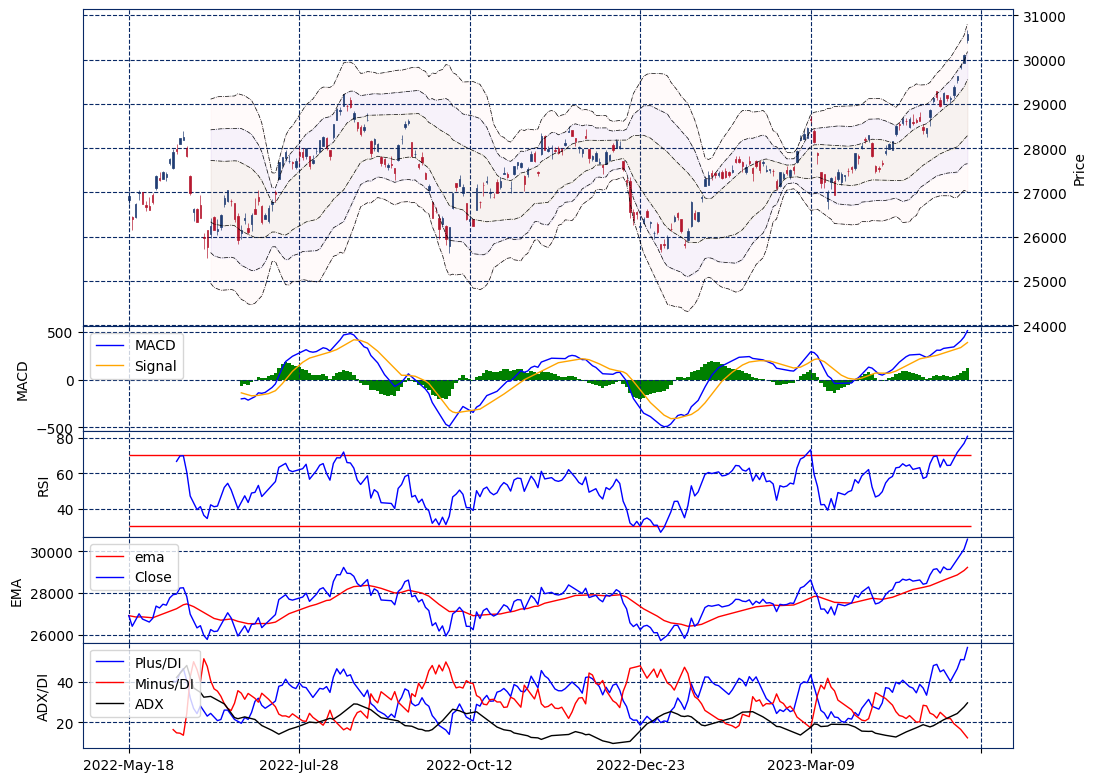

In [14]:
from matplotlib.gridspec import GridSpec

def figure(pdf: pd.DataFrame, 
           adxDF: pd.DataFrame, 
           bbDF: pd.DataFrame, 
           macdDF: pd.DataFrame, 
           rsiDF: pd.DataFrame, 
           emaDF: pd.DataFrame):
    
    fig = mpf.figure(figsize=(12, 9.6), style='starsandstripes')
    #gs = fig.add_gridspec(5, 1, hspace=0, wspace=0, height_ratios=(3,1,1,1,1))
    gs = GridSpec(5, 1, hspace=0, wspace=0, height_ratios=(3,1,1,1,1), figure=fig)
    (ax1,ax2,ax3,ax4,ax5) = gs.subplots(sharex='col')

    bbargs = dict(ax=ax1, width=.5, linestyle='dashdot', color='black')
    macdargs = dict(ax=ax2, width=1, ylabel='MACD')
    rsiargs = dict(ax=ax3, width=1, ylabel='RSI')
    emaargs = dict(ax=ax4, width=1, ylabel='EMA')
    adxdiargs = dict(ax=ax5, width=1, ylabel='ADX/DI')
    
    ap = [
        mpf.make_addplot(bbDF, **bbargs),
        mpf.make_addplot(macdDF["macd"], **macdargs, color='blue'),
        mpf.make_addplot(macdDF["macdsignal"], **macdargs, color='orange'),
        mpf.make_addplot(macdDF["macdhist"], **macdargs, color='green', type='bar'),
        mpf.make_addplot(rsiDF["rsi"], **rsiargs, color='blue'),
        mpf.make_addplot(emaDF["ema"], **emaargs, color='red'),
        mpf.make_addplot(pdf["Close"], **emaargs, color='blue'),
        mpf.make_addplot(adxDF["pdi"], **adxdiargs, color='blue'),
        mpf.make_addplot(adxDF["mdi"], **adxdiargs, color='red'),
        mpf.make_addplot(adxDF["adx"], **adxdiargs, color='black'),
    ]

    # ボリンジャーバンド(axes=1)の間を塗りつぶす
    ax1.fill_between(x=range(0, len(pdf.index)), y1=bbDF["bbh3"].values, y2=bbDF["bbl3"].values, alpha=0.02, color='red')
    ax1.fill_between(x=range(0, len(pdf.index)), y1=bbDF["bbh2"].values, y2=bbDF["bbl2"].values, alpha=0.03, color='blue')
    ax1.fill_between(x=range(0, len(pdf.index)), y1=bbDF["bbh1"].values, y2=bbDF["bbl1"].values, alpha=0.04, color='yellow')

    # RSI(axes=3) の30%と70%に線を引く
    ax3.hlines(xmin=0, xmax=len(pdf.index), y=30, linewidth=1, color='red')
    ax3.hlines(xmin=0, xmax=len(pdf.index), y=70, linewidth=1, color='red')
    
    # EMA
    ema_max_value = max(pdf['Close'].max(), emaDF['ema'].max()) + 100
    ema_min_value = min(pdf['Close'].min(), emaDF['ema'].min()) - 100
    ax4.set_ylim(ema_min_value, ema_max_value)

    # ローソク足
    mpf.plot(pdf, ax=ax1, addplot=ap, style='starsandstripes', type='candle', xrotation=30, ylabel='Price', returnfig=True)
    
    # MACD
    handles_macd = ax2.get_legend()
    ax2.legend(handles=handles_macd, loc='upper left', labels=['MACD', 'Signal'])
    
    # EMA
    handles_ema = ax4.get_legend()
    ax4.legend(handles=handles_ema, loc='upper left', labels=['ema', 'Close'])
   
    # ADX/DI
    handles_adx_di = ax5.get_legend()
    ax5.legend(handles=handles_adx_di, loc='upper left', labels=['Plus/DI', 'Minus/DI', 'ADX']) 
    
    return mpf,fig

(mpf, fig) = figure(pdf, adxDF, bbDF, macdDF, rsiDF, emaDF)

mpf.show()

In [15]:
summeryDF = pd.concat([pdf, adxDF, macdDF, rsiDF, emaDF], axis=1)

In [16]:
message = summeryDF.tail(1).to_csv()

In [17]:
display(summeryDF.tail(1))

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pdi,mdi,adx,macd,macdsignal,macdhist,rsi,ema_signal,ema,ema_positions
Date,,,,,,,,,,,,,,,,,
2023-05-18 00:00:00+09:00,30432.539062,30667.130859,30381.900391,30573.929688,0,0.0,0.0,56.774516,12.453828,29.609496,514.647644,390.163411,124.484233,80.750183,1.0,29222.641748,0.0


In [18]:
message

'Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,pdi,mdi,adx,macd,macdsignal,macdhist,rsi,ema_signal,ema,ema_positions\n2023-05-18 00:00:00+09:00,30432.5390625,30667.130859375,30381.900390625,30573.9296875,0,0.0,0.0,56.7745156620716,12.453828282804722,29.609495615889255,514.6476440211518,390.16341105085496,124.48423297029683,80.75018264581821,1.0,29222.64174779001,0.0\n'

In [19]:
import openai
openai.api_key = OPEN_AI_KEY

def get_ai_message(message:str):
    completion = openai.ChatCompletion.create(
                    model    = "gpt-3.5-turbo",     
                    messages = [        
                        {"role": "system", "content": "あなたは金融系のクオンツです。与えられたデータ内のadx、macd、ema、rsiの分析してマークダウンで教えてください。"},
                        {"role": "user", "content": message}
                    ],
                    max_tokens  = 1024, 
                    n           = 1,
                    stop        = None,
                    temperature = 0,
    )
    response = completion.choices[0].message.content
    return response

In [22]:
ai_message = get_ai_message(message)

In [23]:
print(ai_message)

このデータを見ると、以下のような分析ができます。

- ADX（Average Directional Index）は、トレンドの強さを示す指標です。このデータでは、ADXは29.61となっており、トレンドがある程度強いことを示しています。
- MACD（Moving Average Convergence Divergence）は、短期と長期の移動平均線の差を表す指標です。このデータでは、MACDは514.65、MACDシグナルは390.16となっており、MACDがシグナルを上回っていることから、上昇トレンドが続く可能性があります。
- RSI（Relative Strength Index）は、買われすぎ・売られすぎの状態を示す指標です。このデータでは、RSIは80.75となっており、買われすぎの状態にあることを示しています。
- EMA（Exponential Moving Average）は、過去の価格データを元に算出される移動平均線の一種です。このデータでは、EMAは29222.64となっており、現在の価格がEMAよりも高いことから、上昇トレンドが続く可能性があります。

以上のように、このデータからは上昇トレンドが続く可能性があることが示唆されています。ただし、RSIが買われすぎの状態にあるため、調整が入る可能性もあります。また、ADXがある程度強いことから、トレンドが継続する可能性が高いと考えられます。
